<a href="https://colab.research.google.com/github/s-shahpouri/DL_PET/blob/main/Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import pydicom" || pip install pydicom
!python -c "import dicom2nifti" ||pip install dicom2nifti



from monai.utils import first, set_determinism
from monai.transforms import (EnsureChannelFirstd, Compose, CropForegroundd, LoadImaged, Orientationd, RandCropByPosNegLabeld, ScaleIntensityRanged, Spacingd)
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset
from monai.apps import download_and_extract
from monai.transforms import CenterSpatialCropd
from monai.transforms import Resized
import torch
import matplotlib.pyplot as plt
import os
import glob
import torch.nn as nn
from google.colab import drive
from datetime import datetime


Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 266.5/266.5 kB 2.2 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'pydicom'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 5.6 MB/s eta 0:00:00
Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'dicom2nifti'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 498.2 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 53.2 MB/s eta 0:00:00


In [2]:
drive.mount('/content/drive')
data_dir = '/content/drive/My Drive/PET_data/ASC-PET-001'
directory='/content/drive/My Drive/PET_data/LOG'

Mounted at /content/drive


## Set dataset path

In [22]:

train_images = sorted(glob.glob(os.path.join(data_dir, "NAC", "*.nii.gz")))
target_images = sorted(glob.glob(os.path.join(data_dir, "MAC", "*.nii.gz")))

# data_dicts = [{"image": img, "target": tar} for img in train_images]
data_dicts = [{"target": tar} for tar in target_images]

# making  smaller input to save time for practing stage:
# train_files, val_files =  data_dicts[:20], data_dicts[-1:]
val_files = data_dicts[-1:]
# Extracting file names from val_files
val_file_names = [os.path.basename(file_dict["target"]) for file_dict in val_files]

set_determinism(seed=0)


In [13]:
crop_size = (180, 180, 312)  # Adjusted based on my data

val_transforms = Compose(
    [   LoadImaged(keys=["image", "target"]),
        EnsureChannelFirstd(keys=["image", "target"]),
        Spacingd(keys=["image", "target"], pixdim=(1.5, 1.5, 2.0)),
        Resized(keys=["image", "target"], spatial_size=crop_size, mode=('bilinear')),
        # CenterSpatialCropd(keys=["image", "target"], roi_size=crop_size, lazy=True),

    ])


val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=1)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=1)



Loading dataset: 100%|██████████| 1/1 [00:02<00:00,  2.83s/it]


In [ ]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, target = (check_data["image"][0][0], check_data["target"][0][0])
print(f"image shape: {image.shape}, target shape: {target.shape}")
# plot the slice [:, :, n]
n = 100

plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, n, :], cmap="gist_yarg")
plt.subplot(1, 2, 2)
plt.title("target")
plt.imshow(target[:, n, :],cmap='gist_yarg' )
plt.show()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=3,
    in_channels=1,
    out_channels=1,
    channels=(16, 32, 64),
    # default=[32, 64, 128, 256, 512, 32] MRI Recon
    act=(nn.ReLU6, {"inplace": True}),
    strides=(2, 2),
  num_res_units=2,
    norm=Norm.BATCH,
).to(device)

loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-4)

# max_epochs = 10
# val_interval = 2
# best_metric = float('inf')
# best_metric_epoch = -1
# epoch_loss_values = []
# metric_values = []
# train_losses = []
# val_losses = []
# trainer = ModelTrainer(model, train_loader, val_loader, optimizer, loss_function, max_epochs, val_interval,directory)
# trainer.log()
# trainer.train()

In [7]:
def find_last_saved_model(log_filepath):
    last_saved_model = None
    best_metric = None
    epoch = None
    with open(log_filepath, 'r') as file:
        for line in file:
            if "Saved" in line and ".pth" in line:
                parts = line.split(',')
                last_saved_model = parts[0].split()[1]  # Extract model filename
                best_metric = float(parts[1].split(': ')[1])  # Extract best metric
                epoch = int(parts[2].split(': ')[1])  # Extract epoch number
    return last_saved_model, best_metric, epoch


log_filename = 'log_1_16_16_35.txt'
log_filepath = directory + '/'+ log_filename
bestmodel_filename, best_metric, best_epoch = find_last_saved_model(log_filepath)
print(f"Model Filename: {bestmodel_filename}, Best Metric: {best_metric}, Epoch: {best_epoch}")


Model Filename: model_1_16_18_1.pth, Best Metric: 0.1553, Epoch: 50


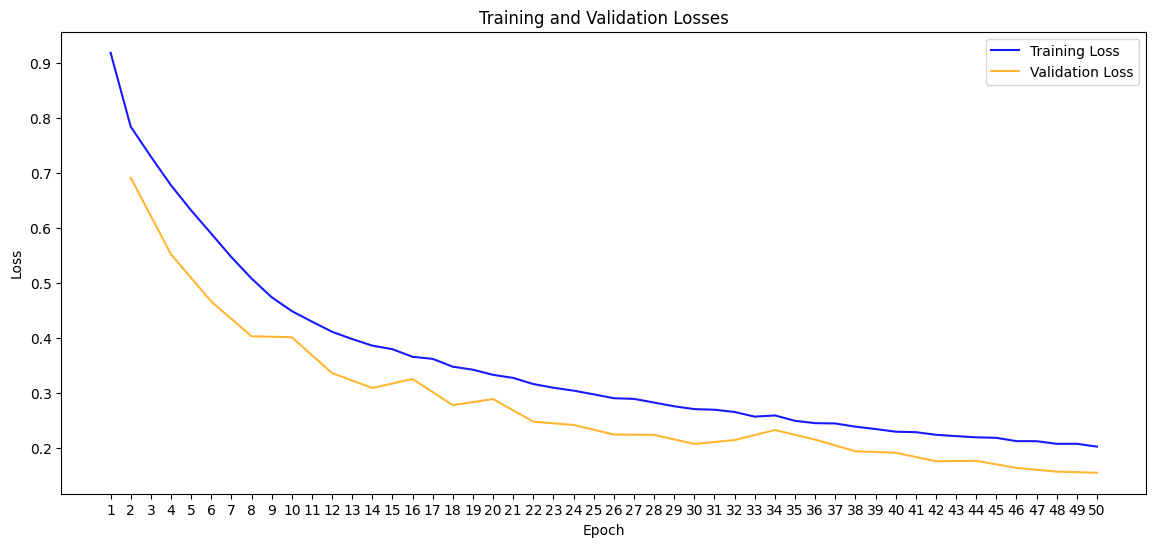

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Function to parse the loss values from the log file
def parse_loss_values(log_filepath):
    train_losses = []
    val_losses = []
    with open(log_filepath, 'r') as file:
        for line in file:
            if 'average loss:' in line:
                loss_value = float(line.split(': ')[-1])
                train_losses.append(loss_value)
            if 'Validation loss:' in line:
                val_loss_value = float(line.split(': ')[-1])
                val_losses.append(val_loss_value)
    return train_losses, val_losses

# Replace this with the path to your actual log file

train_losses, val_losses = parse_loss_values(log_filepath)

max_epochs = len(train_losses)
val_interval = 2  # Update this if your validation interval is different

# Plotting
plt.figure(figsize=(14, 6))
plt.plot(range(1, max_epochs + 1), train_losses, label='Training Loss', color='blue', alpha=0.9)
plt.plot(range(2, max_epochs + 1, val_interval), val_losses, label='Validation Loss', color='orange', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.xticks(np.arange(1, max_epochs + 1, 1))  # Adjust the x-axis ticks if needed
plt.show()


In [8]:
import torch

# Assuming root_dir is the directory where your model files are stored
model_path = os.path.join(directory, bestmodel_filename)
if os.path.exists(model_path):
    print(f"Model file {bestmodel_filename} is loading.")
    # Load the model onto the CPU
    model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
    model.eval()
else:
    print(f"Model file {bestmodel_filename} not found.")


Model file model_1_16_18_1.pth is loading.


100%|██████████| 1/1 [00:12<00:00, 12.78s/it]


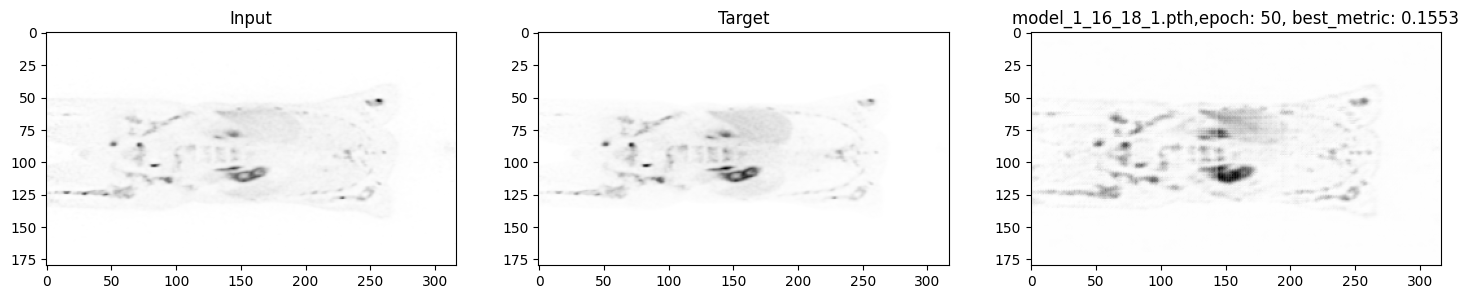

In [14]:
# Define a function for visualization
def visualize_results(val_data, model, n, title):

    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size,
                          sw_batch_size, model, progress=True, overlap=0.20) # using ov= 0.9 best image ever I have.

    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title(f"Input")
    plt.imshow(val_data["image"][0, 0, :, n, :], cmap="gist_yarg")

    plt.subplot(1, 3, 2)
    plt.title(f"Target")
    plt.imshow(val_data["target"][0, 0, :, n, :], cmap="gist_yarg")

    plt.subplot(1, 3, 3)
    plt.title(title)
    output_slice = val_outputs.detach().cpu()[0, 0, :, n, :]
    plt.imshow(output_slice, cmap="gist_yarg")
    plt.show()


roi_size = (80, 80, 80)
sw_batch_size = 64 # Increase the overlap by using a higher sw_batch_size
with torch.no_grad():
    for i, val_data in enumerate(val_loader):

        n = 100
        visualize_results(val_data, model, n, f"{bestmodel_filename},epoch: { best_epoch}, best_metric: {best_metric}")
        if i == 0:
            break




In [23]:
import nibabel as nib
import os
import numpy as np

def save_nifti(data, filename, affine=np.eye(4)):
    """
    Save the data as a NIfTI file.
    Args:
        data: The data to save, typically a NumPy array.
        filename: The filename for the saved NIfTI file.
        affine: The affine matrix for the NIfTI file, defaults to identity.
    """
    nifti_img = nib.Nifti1Image(data, affine)
    nib.save(nifti_img, filename)

def save_output(val_data, model, output_dir, file_name):
    val_outputs = sliding_window_inference(val_data["image"].to(device), roi_size, sw_batch_size, model, progress=True, overlap=0.20)
    output_data = val_outputs.detach().cpu().numpy()[0, 0, :, :, :]  # Assuming single-channel output
    output_file_path = os.path.join(output_dir, file_name)
    save_nifti(output_data, output_file_path)



with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        # Modify the file name for the output
        original_file_name = val_file_names[i]
        output_file_name = f"DL_{original_file_name}"

        # Save the output using the modified file name
        save_output(val_data, model, directory, output_file_name)



100%|██████████| 1/1 [00:13<00:00, 14.00s/it]
